# VAT 4 Machine Learning - Creating Training data for a species distribution model

This workflow is a contribution to the NFDI4Earth conference.

This workflow is a contribution to the NFDI4Earth conference. 
This workflow therefore uses the frequency of *Arnica montana* occurrences from GBIF as a target variable together with weather data from CHELSA, land use classification from the Ökosystematlas and topographic information as predictor variables to create a species distribution model for *Arnica montana* across Germany.

# Import

In [1]:
#Import Packages
import geoengine as ge
from datetime import datetime 
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fiona
import asyncio
import nest_asyncio

In [2]:
#Initialize Geo Engine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [3]:
#Get the GBIF DataProvider id (useful for translating the DataProvider name to its id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

# Create Labelled Data

This chapter shows how to register the workflow for generating training data and how to manipulate this data to generate training data.

In [4]:
#Tuning parameters
time = datetime.strptime('2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
resolution = ge.SpatialResolution(0.01, 0.01)
extent = ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334)

#Species selection
species = "species/Arnica montana" #Arnica

In [5]:
#Create a workflow to retrieve Arnica montana occurrences filtered by the German border and linked to weather, land use and topographic data.
workflow = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Ökosystematlas", "SRTM", "Mean Air Temperature", "Mean Climate Moisture Index", "Precipitation"]
            },  
            "temporalAggregation": "none",
            "featureAggregation": "first",
        },
        "sources": {
            "vector": { #Arnica montana #########################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`{species}`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, 
            "rasters": [{ #Ökosystematlas ########################################
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        },
                    }
                }
            },
            { #SRTM #########################################################
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "srtm"
                        },
                    }
                }
                
            },
            { #Mean Annual Air Temperature ##################################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "mean",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": -273.15
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "temperature",
                                "unit": "K/10"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "mean_daily_air_temperature"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            },
            { #Mean Annual Climate moisture indices #########################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "mean",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": 0
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "climate moisture",
                                "unit": "kg m^-2 month^-1"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "monthly_climate_moisture_indicies"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            },
            { #Sum Annual Precipitation ####################################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "sum",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": 0
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "precipitation",
                                "unit": "kg m-2 month^-1"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "monthly_precipitation_amount"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }]
        },
    }
})
    
workflow

7582cfcb-3d36-5b86-bb72-e81cef584fae

<Axes: >

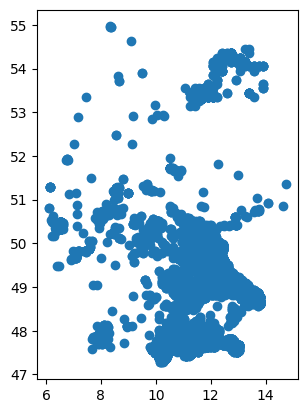

In [6]:
#Request the data from Geo Engine into a geopandas dataframe
data = workflow.get_dataframe(
    ge.QueryRectangle(
        extent,
        ge.TimeInterval(time, time),
        resolution=resolution,
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

In [7]:
data

,geometry,Mean Air Temperature,Mean Climate Moisture Index,Precipitation,SRTM,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (12.12000 49.87000),7.666677,9.616667,831.400024,508.0,HUMAN_OBSERVATION,1920107357,Arnica montana L.,11.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
1,POINT (11.29000 50.47000),6.600011,42.033333,1186.700073,684.0,HUMAN_OBSERVATION,1922039098,Arnica montana L.,12.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
2,POINT (8.03725 47.82348),5.341672,97.166664,2086.199951,1214.0,HUMAN_OBSERVATION,3952238491,Arnica montana L.,10.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
3,POINT (12.96000 48.92000),7.925013,43.450001,1300.299927,498.0,HUMAN_OBSERVATION,1921322253,Arnica montana L.,8.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
4,POINT (12.20880 50.30055),7.366676,6.991667,800.200012,564.0,HUMAN_OBSERVATION,2975824629,Arnica montana L.,11.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
10711,POINT (12.04000 49.02000),9.166677,-6.100000,746.500000,339.0,HUMAN_OBSERVATION,2811597194,Arnica montana subsp. montana,6.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
10712,POINT (9.79000 50.42000),7.508349,23.783335,957.500061,688.0,HUMAN_OBSERVATION,2811807788,Arnica montana subsp. montana,13.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
10713,POINT (12.96000 49.12000),7.175011,54.550003,1323.200073,727.0,HUMAN_OBSERVATION,2811958730,Arnica montana subsp. montana,11.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00
10714,POINT (13.12000 48.87000),6.625010,42.166668,1311.100098,642.0,HUMAN_OBSERVATION,1920729124,Arnica montana L.,12.0,2000-01-01 00:00:00+00:00,2001-01-01 00:00:00+00:00


In [8]:
#Rounding and grouping of occurrences to create frequency along with predictor variable combination
training_data = data.round(3)
training_data = training_data.groupby(['Mean Air Temperature', 'Mean Climate Moisture Index', 'Precipitation', 'SRTM', 'Ökosystematlas']).size().reset_index(name='counts')
training_data

,Mean Air Temperature,Mean Climate Moisture Index,Precipitation,SRTM,Ökosystematlas,counts
0,-1.808,123.483,2226.8,2177.0,14.0,1
1,-0.842,126.342,2321.8,2036.0,14.0,14
2,-0.717,178.900,2899.2,1938.0,16.0,3
3,0.025,99.475,1852.6,2049.0,16.0,1
4,0.217,119.000,2200.7,1788.0,255.0,5
...,...,...,...,...,...,...
2772,10.350,-10.800,583.6,101.0,5.0,1
2773,10.350,-0.683,723.0,110.0,10.0,1
2774,10.508,0.025,874.0,37.0,2.0,1
2775,10.667,0.325,756.8,99.0,2.0,1


In [9]:
training_data.sort_values('counts', ascending=False)

,Mean Air Temperature,Mean Climate Moisture Index,Precipitation,SRTM,Ökosystematlas,counts
752,7.042,33.925,1123.1,565.0,13.0,112
1195,7.650,45.308,1330.4,707.0,12.0,99
790,7.092,42.258,1326.8,808.0,11.0,92
170,4.950,69.375,1577.6,1102.0,12.0,63
273,5.850,128.183,2370.3,1072.0,8.0,56
...,...,...,...,...,...,...
1245,7.708,32.633,1182.7,538.0,8.0,1
1244,7.708,29.908,1096.0,633.0,11.0,1
1243,7.708,28.117,1056.8,494.0,11.0,1
1240,7.700,33.892,1240.5,719.0,17.0,1


# Create Prediction Data

This chapter shows how to register the workflow to create prediction data.

In [10]:
#Create a workflow to request weather, land use and topographic data as a raster stack.
prediction_workflow = ge.register_workflow({
    "type": "Raster",
    "operator": {
          "type": "RasterStacker",
          "params": {
            "renameBands": {
              "type": "rename",
              "values": ["Ökosystematlas", "SRTM", "Mean Air Temperature", "Mean Climate Moisture Index", "Precipitation"]
            }
          },
          "sources": {
            "rasters": [{ #Ökosystematlas ########################################
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        },
                    }
                }
            },
            { #SRTM #########################################################
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "srtm"
                        },
                    }
                }
                
            },
            { #Mean Annual Air Temperature ##################################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "mean",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": -273.15
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "temperature",
                                "unit": "K/10"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "mean_daily_air_temperature"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            },
            { #Mean Annual Climate moisture indices #########################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "mean",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": 0
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "climate moisture",
                                "unit": "kg m^-2 month^-1"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "monthly_climate_moisture_indicies"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            },
            { #Sum Annual Precipitation ####################################
                "type": "TemporalRasterAggregation",
                "params": {
                    "aggregation": {
                        "type": "sum",
                        "ignoreNoData": False
                    },
                    "window": {
                        "granularity": "years",
                        "step": 1
                    },
                    "windowReference": None,
                    "outputType": None,
                },
                "sources": {
                    "raster": {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": 0
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "precipitation",
                                "unit": "kg m-2 month^-1"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "monthly_precipitation_amount"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }]
          }
        }
    
})

prediction_workflow

370296a3-db66-599b-8e55-2a4bf362a09a

In [11]:
#Preparing of the boundaries for the workflow raster stream
bbox = ge.QueryRectangle(
    extent,
    ge.TimeInterval(time, time),
    resolution=resolution,
    srs="EPSG:4326"
)

In [12]:
nest_asyncio.apply()

async def get_prediction_data(workflow, bbox, bands=[0,1,2,3,4], clip=True):
    data = await workflow.raster_stream_into_xarray(bbox, bands=bands, clip_to_query_rectangle=clip)
    data.to_dataset(name="prediction")
    return data

async def main(extent, time, resolution, workflow):
    bbox = ge.QueryRectangle(extent, ge.TimeInterval(time, time), resolution=resolution, srs="EPSG:4326")
    return await get_prediction_data(workflow, bbox)

try:
    loop = asyncio.get_event_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

prediction_data = loop.run_until_complete(main(extent, time, resolution, prediction_workflow))
prediction_data.to_dataset(name="prediction")

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.Dataset> Size: 14MB
Dimensions:      (x: 918, y: 780, time: 1, band: 5)
Coordinates:
  * x            (x) float64 7kB 5.855 5.865 5.875 5.885 ... 15.0 15.01 15.02
  * y            (y) float64 6kB 55.07 55.06 55.05 55.04 ... 47.3 47.29 47.28
  * time         (time) datetime64[ns] 8B 2000-01-01
  * band         (band) int64 40B 0 1 2 3 4
    spatial_ref  int64 8B 0
Data variables:
    prediction   (time, band, y, x) float32 14MB 21.0 21.0 ... 1.082e+03

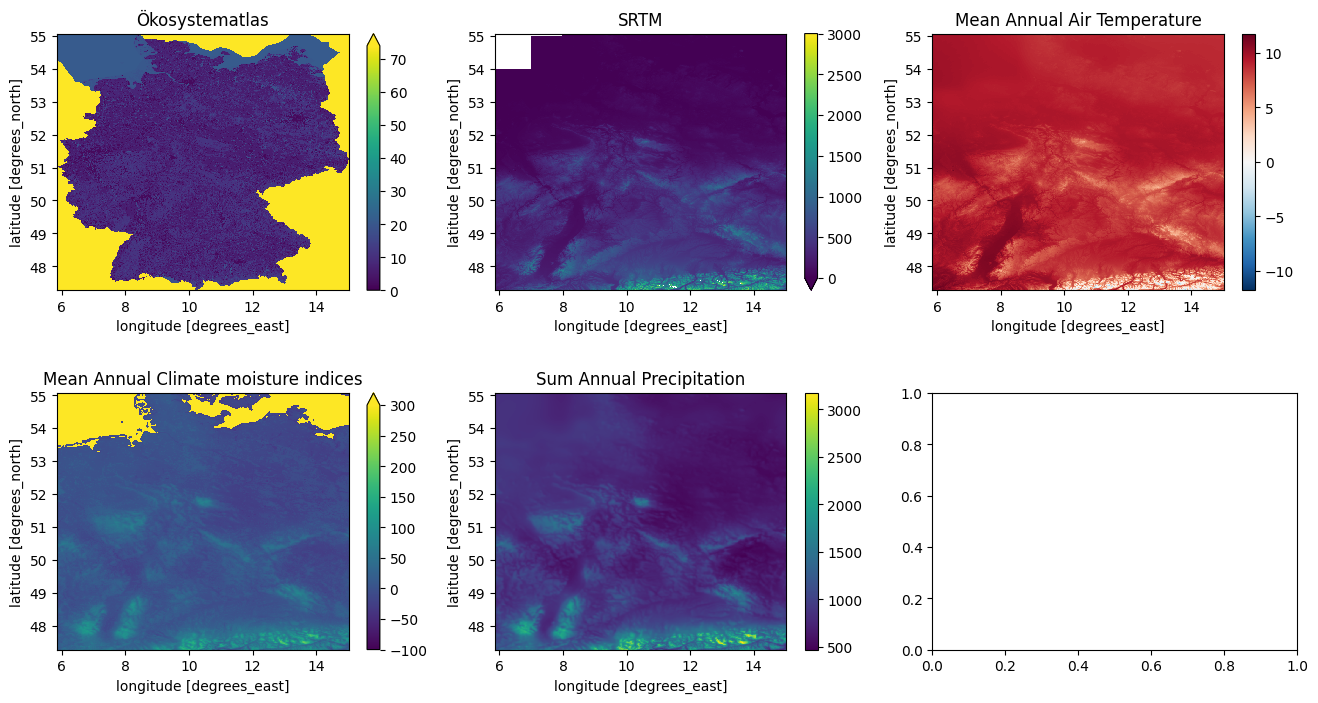

In [13]:
#Plotting the Layers of the returned xarray dataarray
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axes[0, 0].set_ylim(-0.01, 1.01)
axes[0, 1].set_ylim(-0.01, 1.01)
axes[0, 2].set_ylim(-0.01, 1.01)
axes[1, 0].set_ylim(-0.01, 1.01)
axes[1, 1].set_ylim(-0.01, 1.01)

# Add your plot data and other customizations to each subplot
prediction_data.isel(band=0).plot(ax=axes[0, 0], vmin=0, vmax=74)
prediction_data.isel(band=1).plot(ax=axes[0, 1], vmin=0, vmax=3000)
prediction_data.isel(band=2).plot(ax=axes[0, 2])
prediction_data.isel(band=3).plot(ax=axes[1, 0], vmin=-100, vmax=300)
prediction_data.isel(band=4).plot(ax=axes[1, 1])

axes[0, 0].set_title("Ökosystematlas")
axes[0, 1].set_title("SRTM")
axes[0, 2].set_title("Mean Annual Air Temperature")
axes[1, 0].set_title("Mean Annual Climate moisture indices")
axes[1, 1].set_title("Sum Annual Precipitation")

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()

# Machine Learning

In this chapter, the training data is used to create a simple RandomForestRegressor model, which is hyperparameterised using a GridSearchCV and the best model is selected for prediction later.

In [14]:
#Create training and test data
X = training_data[['Mean Air Temperature', 'Mean Climate Moisture Index', 'Precipitation', 'SRTM', 'Ökosystematlas']]
y = training_data['counts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Create the random forest regressor model
rf = RandomForestRegressor()

#Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=4, verbose=2)
grid_search.fit(X_train, y_train)

#Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_le

In [16]:
best_params

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 400}

In [17]:
#Simple prediction on the training data
y_pred = best_model.predict(X_test)

#Model performance using r2
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.2f}")

R2 score: 0.07


# Prediction

In this chapter the best model is chosen and used to predict on the prediction data, for the whole of Germany.

In [18]:
# Flatten the xarray dataset to a 2D array
prediction_df = prediction_data.to_dataset(dim="band").to_dataframe().reset_index()
X_pred = prediction_df.loc[:, [0, 1, 2, 3, 4]]
X_pred.columns = ["Ökosystematlas", "SRTM", "Mean Air Temperature", "Mean Climate Moisture Index", "Precipitation"]
X_pred = X_pred[['Mean Air Temperature', 'Mean Climate Moisture Index', 'Precipitation', 'SRTM', 'Ökosystematlas']]

# Use the trained model to make predictions
y_pred = best_model.predict(X_pred)
y_pred_log = np.log(y_pred)
y_pred

array([7.67237854, 7.65707952, 7.65707952, ..., 8.38158869, 7.15299211,
       6.7590327 ])

In [19]:
#Extract coordinates for spatial alignment
prediction_ds = prediction_data.to_dataset(name='prediction_data')
x_coords = prediction_ds.coords['x'].values
y_coords = prediction_ds.coords['y'].values

In [20]:
#Reshape the model prediction for plotting
y_pred_reshaped = y_pred.reshape(prediction_data.time.size, 1, prediction_data.y.size, prediction_data.x.size)
da = xr.DataArray(y_pred_reshaped, dims=['time', 'band', 'y', 'x'])
da = da.assign_coords(x=x_coords, y=y_coords)
da.rio.write_crs('EPSG:4326', inplace=True)

#Reshape the model prediction for plotting
y_pred_reshaped_log = y_pred_log.reshape(prediction_data.time.size, 1, prediction_data.y.size, prediction_data.x.size)
da_log = xr.DataArray(y_pred_reshaped_log, dims=['time', 'band', 'y', 'x'])
da_log = da_log.assign_coords(x=x_coords, y=y_coords)
da_log.rio.write_crs('EPSG:4326', inplace=True)

<xarray.DataArray (time: 1, band: 1, y: 780, x: 918)> Size: 6MB
array([[[[2.03762668, 2.03563065, 2.03563065, ..., 0.99351941,
          0.92776581, 0.99139416],
         [2.03762668, 2.03563065, 2.03563065, ..., 1.090834  ,
          1.08062439, 1.08319474],
         [2.03563065, 2.03563065, 2.03563065, ..., 1.05180356,
          1.05180356, 1.05178669],
         ...,
         [1.33849233, 1.34576798, 1.33672885, ..., 1.19804641,
          1.15003662, 1.14325111],
         [1.33672885, 1.33672885, 1.33672885, ..., 1.9488662 ,
          2.30133087, 1.12419594],
         [1.33672885, 1.33672885, 1.35778598, ..., 2.12603748,
          1.96753075, 1.91087979]]]])
Coordinates:
  * x            (x) float64 7kB 5.855 5.865 5.875 5.885 ... 15.0 15.01 15.02
  * y            (y) float64 6kB 55.07 55.06 55.05 55.04 ... 47.3 47.29 47.28
    spatial_ref  int64 8B 0
Dimensions without coordinates: time, band

In [21]:
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

In [22]:
#Request the data from Geo Engine into a geopandas dataframe
germany = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        extent,
        ge.TimeInterval(time, time),
        resolution=resolution,
        srs="EPSG:4326"
    )
)

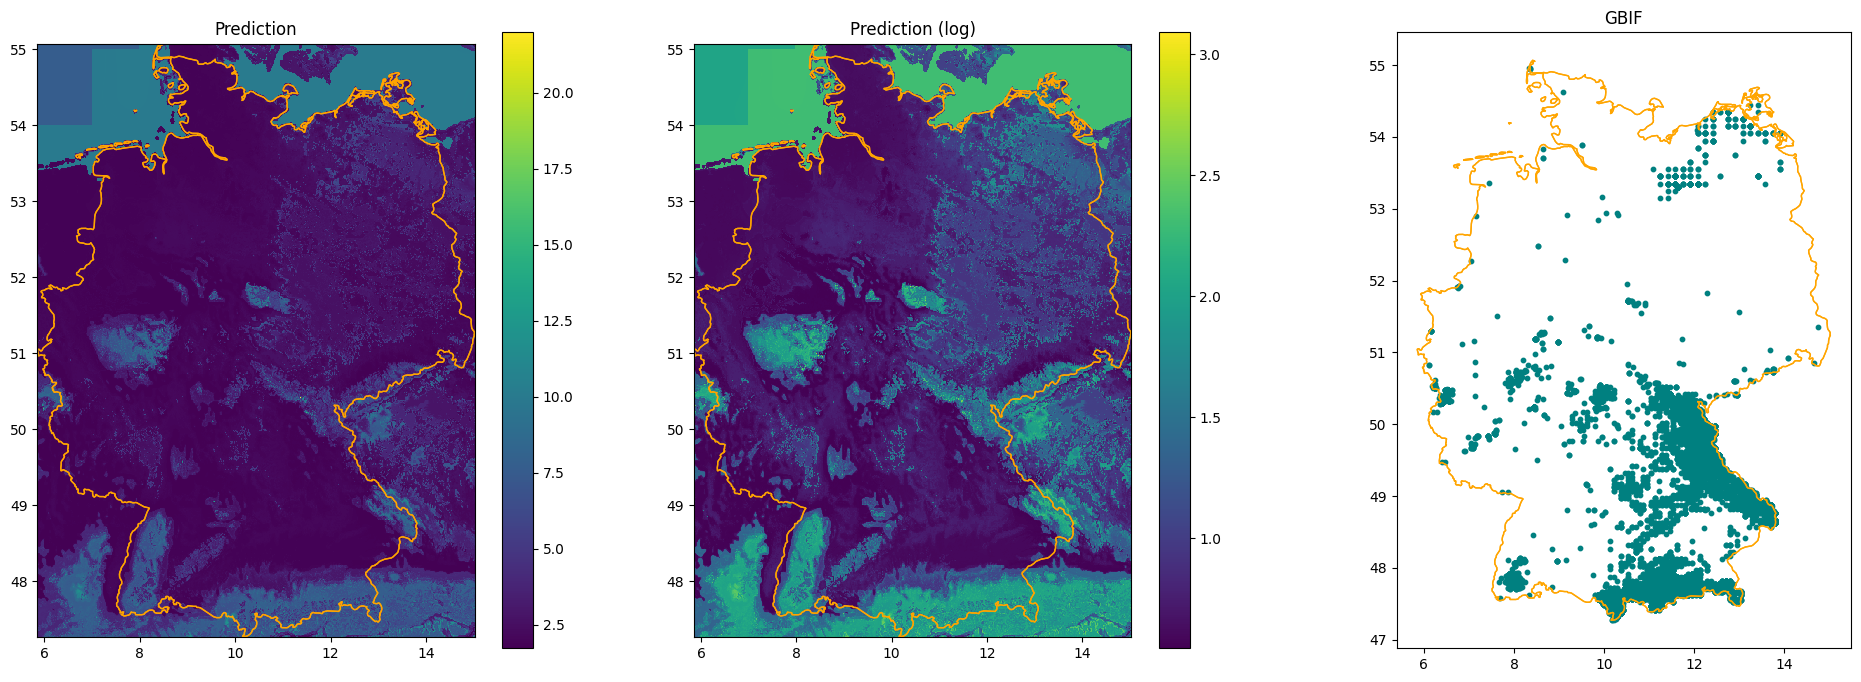

[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   2.6s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   3.2s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   3.2s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.9s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.9s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   2.6s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   3.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400; to

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
da.plot(ax=axes[0], cmap='viridis')
germany.boundary.plot(ax=axes[0], color='orange', linewidth=1)
axes[0].set_title("Prediction")
axes[0].set_xlabel('')
axes[0].set_ylabel('')

da_log.plot(ax=axes[1], cmap='viridis')
germany.boundary.plot(ax=axes[1], color='orange', linewidth=1)
axes[1].set_title("Prediction (log)")
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Vector plot
data.plot(ax=axes[2], markersize=10, color='teal')
germany.boundary.plot(ax=axes[2], color='orange', linewidth=1)
axes[2].set_title("GBIF")
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.show()